In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

In [3]:
len(range(5))-1

4

In [75]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import curve_fit

class AetasStellae():
    '''
    A class to calculate a star's age and extinction using PARSEC isochrones and extinction law
    from Cardelli et al. 1989 by fitting Gaia (BP, RP) and 2MASS (J,H,K) photometry
    '''
    def __init__(self,teff,feh,cnalpha,obsphot,obsphot_err,distance,isochrones,rv=3.1):
        
        '''
        teff: [float] Teff of star
        feh: [float] metallicity [Fe/H] of star
        cnalpha: [array] [C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe]
        phot: [array] observed [BP,RP,J,H,K] photometry
        phot_err: [array] observed [BP,RP,J,H,K] photometry error
        distance: [float] distance to star in pc
        isochrones: [astropy Table] PARSEC isochrone table
        rv: [float] Rv value (=Av/E(B_V)) 
        '''
        
        # Observed Quantities
        self.teff = teff # temperature
        self.salfeh = self.salariscorrectedfeh(feh,cnalpha) # Metallicity
        self.phot = obsphot # photometry
        self.phot_err = obsphot_err # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # PARSEC isochrones
        self.rv = rv
        self.labels = ['G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']
        
        self.uniq_ages = np.unique(isochrones['logAge'])
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPmag':0.5387,'Gmag':0.6419,'G_RPmag':0.7667,'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    def salariscorrectedfeh(self,feh,cnalpha):
        '''
        Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
        Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
        Inputs:
        ------
            feh: metallcity of a star
            cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
        Output:
        ------
            salfeh: Salaris corrected metallicity
        '''
        # hydrogen_wgt = 1.008 #IUPAC
        # atomic_wgts = np.array([12.011,14.007,15.999,24.305,28.085,32.06,40.078,47.867]) #IUPAC
        # asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95]) #Asplund et al. 2009
        # ZX_sol = 0.0181 # (Z/X) Asplund et al. 2009
        # a = sum(10**(asplund-12.00)*(atomic_wgts/hydrowh_wgt)*(1/0.0181)) # a = 0.78963627131196057
        # b = 1-a # b = 0.21036372868803943
        
        asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
        # assign solar value to stars if abundance is bad
        for j in range(len(cnalpha)):
            if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
                cnalpha[j] = 0.0
                
        if np.isfinite(feh)==False:
            feh = 0.0
        
        # Calculate enhancement factor and corrected metallicity
        fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
        salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
        return salfeh 
    
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value
        
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        '''
        
        data = np.asarray(data)
    
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value
    
        Inputs:
        ------
            data: data to search through 
            value: value of interest
        
        Output:
        ------
            close1: closest value under the given value
            close2: closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def cardelli_a(self,x):
        '''
        a(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            a: a function value  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def cardelli_b(self,x):
        '''
        b(x) function from Cardelli et al. 1989
    
        Input:
        -----
            x: effective wavelength in units of 1/micron
        
        Output:
        ------
            b: b function value 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def cardelli_alav(self,wave):
        '''
        Calculate A\lambda/Av
    
        Inputs:
        ------
            wave: effective wavelength in units of micron
        
        Output:
        ------
            alav: A\lambda/Av
        '''
        x=1/wave
        alav = self.cardelli_a(x)+self.cardelli_b(x)/self.rv
        return alav    
        
    def teff2appmags(self,teff,age,ak,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.cardelli_alav(self.leff['G_BPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        arpak = self.cardelli_alav(self.leff['G_RPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ajak = self.cardelli_alav(self.leff['Jmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ahak = self.cardelli_alav(self.leff['Hmag'])/self.cardelli_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
    
    def fit(self,guess_ages=np.arange(0,14),guess_aks=np.array([0,0.5,1.0]),verbose=False):
        '''
        Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
        age and extinction.
        
        Inputs:
        ------
            guess_ages: [array] initial guesses for ages in Gyr
            guess_aks: [array] initial guesses for Ak 
            
        Output:
        ------
            best_params: [array] best fitting age and Ak 
            best_params_err:
        '''
            
        # initialize lists
        curve_ages = []
        curve_aks = []
        curve_ages_err = []
        curve_aks_err = []
        curve_chi = []

        # loop over age and ak space 
        for j in range(len(guess_ages)):
            for k in range(len(guess_aks)):  
                try:
                    # calculate best fit parameters and covariance matrix
                    popt,pcov = curve_fit(self.teff2appmags,self.teff,self.phot,p0=[guess_ages[j],guess_aks[k]],
                                              bounds=((0.,0.),(14.,2.)),method='trf',
                                          sigma=self.phot_err,absolute_sigma=True,
                                              maxfev=5000)

                    # populate lists
                    curve_ages.append(popt[0])
                    curve_aks.append(popt[1])
                    curve_ages_err.append(np.sqrt(pcov[0][0]))
                    curve_aks_err.append(np.sqrt(pcov[1][1]))
                    curve_mags = np.asarray(self.teff2appmags(self.teff,popt[0],popt[1]))
                    curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2))

                except:
                    #populate lists
                    curve_mags = 999999.0*np.ones(5)
                    curve_ages.append(999999.0)
                    curve_aks.append(999999.0)
                    curve_ages_err.append(999999.0)
                    curve_aks_err.append(999999.0)
                    curve_chi.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        chi = np.min(curve_chi)
        age = np.asarray(curve_ages)[idx]
        ak = np.asarray(curve_aks)[idx]
        age_err = np.asarray(curve_ages_err)[idx]
        ak_err = np.asarray(curve_aks_err)[idx]

        best_params = np.array([age,ak])
        best_params_err = np.array([age_err,ak_err])
        best_mags = self.teff2appmags(self.teff,age,ak)

        if verbose:
            print('Best Fit Params [Age, Ak]:',np.round(best_params,3))
            print('Best Fit Params Err [Age, Ak]:',np.round(best_params_err,3))
            print('Best Fit [BP,RP,J,H,K]: ',np.round(best_mags,3))
            print('Obs Phot [BP,RP,J,H,K]: ',np.round(self.phot,3))
            print('Obs Phot Err [BP,RP,J,H,K]: ',np.round(self.phot_err,3))

        return best_params, best_params_err
        
    def diagnostic(self,best_fit_params,star_name=None,lit_age=None,filename=None,verbose=False):
        '''
        Create a diagnostic plot for the best fit age and Ak values that is optionally saved
        
        Inputs:
        ------
            best_fit_params: [array]
            lit_age: [float] optional known literature age in Gyr
            filename: [str] optional filename of plot if saving
        '''
        
        # initialize arrays
        ages = np.arange(0,15,0.25)
        theos = 999999.0*np.ones((len(ages),5))
        theos_noext = 999999.0*np.ones((len(ages),5))
    
        # calculate theoretical age for given ages
        for j in range(len(ages)):
            theos[j,:] = self.teff2appmags(self.teff,ages[j],best_fit_params[1]) # use best Ak 
            theos_noext[j,:] = self.teff2appmags(self.teff,ages[j],0) # no extinction
        
        # plot results
        fig, ax = plt.subplots(1,5,figsize=[67,15])
        for i in range(5):
            ax[i].scatter(theos[:,i],ages,s=100,label='Best Fit Ak')
            ax[i].plot(theos[:,i],ages)
            
            ax[i].scatter(theos_noext[:,i],ages,s=100,label='No Ak')
            ax[i].plot(theos_noext[:,i],ages)
            
            ax[i].axhline(best_fit_params[0],c='r',ls='--',label='Best Fit Age',lw=3.0)
            
            if lit_age!=None:
                ax[i].axhline(lit_age,c='k',ls='--',label='Lit Age',lw=3.0)
            
            ax[i].axvline(self.phot[i],ls='--',c='magenta',lw=3.0)
            
            ax[i].set_xlim(self.phot[i]-3.0,self.phot[i]+3.0)
            ax[i].set_ylim(bottom=0.01)
            
            ax[i].set_title(r'{}: {:.3f}'.format(self.labels[i],self.phot[i]))
            ax[i].set_xlabel(r'Magnitude')
            
        ax[0].legend()

        ax[0].set_ylabel('Age')
        
        if star_name!=None:
            plt.suptitle(r'{}; {:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(star_name,best_fit_params[0],
                                                                          best_fit_params[1],self.distance))
        
        else:
            plt.suptitle(r'{:.3f} Gyr; {:.3f} dex; {:.3f} kpc'.format(best_fit_params[0],best_fit_params[1],
                                                                      self.distance))
    
        if filename!=None:
            plt.savefig(filename,bbox_inches='tight')
        plt.show()
        
    def extinct(self,age,verbose=False):
        '''
        Calculate the K band (fiducial band here) extintion by interpolating color index as a function
        of temperature for a given age.

        Inputs:
        ------
        age: [float] age in Gyr

        Output:
        ------
        ak: extinction in the K band
        '''

        #Some calcualtions to set things up
        lgteff = np.log10(self.teff)

        ebpk_k = ((self.cardelli_alav(self.leff['G_BPmag'])-self.cardelli_alav(self.leff['Ksmag']))/
              self.cardelli_alav(self.leff['Ksmag']))
        erpk_k = ((self.cardelli_alav(self.leff['G_RPmag'])-self.cardelli_alav(self.leff['Ksmag']))/
              self.cardelli_alav(self.leff['Ksmag']))
        ejk_k = ((self.cardelli_alav(self.leff['Jmag'])-self.cardelli_alav(self.leff['Ksmag']))/
             self.cardelli_alav(self.leff['Ksmag']))
        ehk_k = ((self.cardelli_alav(self.leff['Hmag'])-self.cardelli_alav(self.leff['Ksmag']))/
             self.cardelli_alav(self.leff['Ksmag']))

        ccm = np.array([ebpk_k,erpk_k,ejk_k,ehk_k])

        lgage = np.log10(age*10**9)

        if verbose:
            print('Input [Age, teff, Salaris [Fe/H]]: ',[age,self.teff,self.salfeh])

        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:

            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]

            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])

            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('Ak: ',999999.0)
                self.ak = 999999.0
#                 return 999999.0

            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]

            ### use a spline to get the intrinsic color and calculate the reddening
            calc_reds = 999999.*np.ones(4)
            for i in range(4):
                color_spl = IUS(slogTe,(iso_[self.labels[i]]-iso_['Ksmag'])[sidx][uidx])
                calc_reds[i] = (self.phot[i]-self.phot[4])-color_spl(lgteff)

            ### calculate the Ak value
            calc_ak = np.median(np.divide(calc_reds,ccm))

            if verbose:
                print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                print(ccm)
                print(np.divide(calc_reds,ccm))
                print('Calc Ak: ',calc_ak)
            self.ak = calc_ak
#             return calc_ak

        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])

            ### Pick out single isochrones

            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]

            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]

            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])

            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('Ak: ',999999.0)
                self.ak = 999999.0   
#                 return 999999.0
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('Ak: ',999999.0)
                self.ak = 999999.0
#                 return 999999.0

            ### sort so temp is always increasing

            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]

            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]

            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_reds = 999999.*np.ones(4)
            for i in range(4):
                color_spl_lo = IUS(slogTe_lo,(iso_lo[self.labels[i]]-iso_lo['Ksmag'])[sidx_lo][uidx_lo])
                color_spl_hi = IUS(slogTe_hi,(iso_hi[self.labels[i]]-iso_hi['Ksmag'])[sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(
                    np.polyfit([age_lo,age_hi],[color_spl_lo(lgteff),color_spl_hi(lgteff)],1)))
                if verbose:
                    print(age_spl_interp)
                    print(lgteff)
                    print(age_spl_interp(lgteff))
                    print(self.phot[i]-self.phot[4])
                calc_reds[i] = (self.phot[i]-self.phot[4])-age_spl_interp(age)

            ### calculate the Ak value
            calc_ak = np.median(np.divide(calc_reds,ccm))

            if verbose:
                print('[ebpk,erpk,ejk,ehk]: ',calc_reds)
                print('CCM: ',ccm)
                print('Ak each band',np.divide(calc_reds,ccm))
                print('Calc Ak: ',calc_ak)
                
            self.ak = calc_ak
#             return calc_ak

    def teff2appmags2(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff: Teff of star 
            age: age of star
            ak: extinction in the 2MASS K band
        
        Output:
        ------
            calc_mag: expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        abpak = self.cardelli_alav(self.leff['G_BPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        arpak = self.cardelli_alav(self.leff['G_RPmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ajak = self.cardelli_alav(self.leff['Jmag'])/self.cardelli_alav(self.leff['Ksmag'])
        ahak = self.cardelli_alav(self.leff['Hmag'])/self.cardelli_alav(self.leff['Ksmag'])
        
        extincts = np.array([abpak,arpak,ajak,ahak,1.0])*self.ak
        
        lgage = np.log10(age*10**9)
        
        if verbose:
            print('Input [Age, Ak]: ',[age,self.ak])
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_['logTe']),max(iso_['logTe'])])
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            sidx = np.argsort(iso_['logTe'])
            slogTe = iso_['logTe'][sidx]
            _, uidx = np.unique(slogTe,return_index=True)
            slogTe = slogTe[uidx]
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 99999.0*np.ones(5)
            for i in range(5):
                mag_spl = IUS(slogTe,iso_[self.labels[i]][sidx][uidx])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                calc_mags0[i] = mag_spl(lgteff)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            if verbose:
                print('lgteff, min, max: ',[lgteff,min(iso_lo['logTe']),max(iso_lo['logTe'])])
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                if verbose:
                    print('[BP,RP,J,H,K]: ',np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0]))
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### sort so temp is always increasing
            
            # younger
            sidx_lo = np.argsort(iso_lo['logTe'])
            slogTe_lo = iso_lo['logTe'][sidx_lo]
            _, uidx_lo = np.unique(slogTe_lo,return_index=True)
            slogTe_lo = slogTe_lo[uidx_lo]
            
            # older
            sidx_hi = np.argsort(iso_hi['logTe'])
            slogTe_hi = iso_hi['logTe'][sidx_hi]
            _, uidx_hi = np.unique(slogTe_hi,return_index=True)
            slogTe_hi = slogTe_hi[uidx_hi]
            
            ### use a spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(5)
            calc_mags0 = 999999.0*np.ones(5)
            for i in range(5):
                mag_spl_lo = IUS(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
                mag_spl_hi = IUS(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                calc_mags0[i] = age_spl_interp(age)+self.distmod
            
            if verbose:
                print('[BP,RP,J,H,K]: ',calc_mags)
                print('No Ext [BP,RP,J,H,K]: ',calc_mags0)
            return calc_mags

In [5]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def cardelli_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def cardelli_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def cardelli_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = cardelli_a(x)+cardelli_b(x)/rv
    return alav

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
    return data[(np.abs(np.subtract(data,value))).argmin()]

# PARSEC

In [6]:
### massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
massive = massive['index','MH','logAge','logTe','logg','Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

# Globular Clusters

In [7]:
### GCS Data
gcs = fits.getdata(
    '/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits.gz'
)

gcs = Table(gcs[np.where((gcs['LOGG']>0.0)&(gcs['FE_H']>-9999.0)&(np.isfinite(gcs['FE_H'])==True))])
gcs = gcs[np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                   (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M15')|
                   (gcs['CLUSTER']=='M19')|(gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|
                   (gcs['CLUSTER']=='M3')|(gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|
                   (gcs['CLUSTER']=='M53')|(gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|
                   (gcs['CLUSTER']=='M68')|(gcs['CLUSTER']=='M71')|(gcs['CLUSTER']=='M79')|
                   (gcs['CLUSTER']=='M92')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                   (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                   (gcs['CLUSTER']=='NGC5053')|(gcs['CLUSTER']=='NGC5466')|(gcs['CLUSTER']=='NGC6304')|
                   (gcs['CLUSTER']=='NGC6388')|(gcs['CLUSTER']=='NGC6752')|(gcs['CLUSTER']=='NGC6760'))]

### DR17
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStarLite-dr17-synspec.fits.gz')
_, gcs_ind, dr17_ind = np.intersect1d(gcs['APOGEE_ID'], dr17['APOGEE_ID'], return_indices=True)

gcsdr17 = dr17[dr17_ind]
gcs = gcs[gcs_ind]
gcs_clus = np.unique(gcs['CLUSTER'])

In [8]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

Harris-APOGEE: -0.07535000324249275
VandenBerg-APOGEE: -0.08275001049041741
Overall: -0.07905000686645508


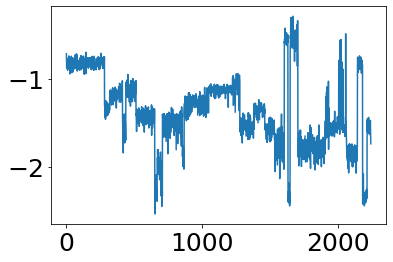

In [9]:
med_apo_feh = np.array([])
for i in range(len(gcs_clus)):
    clus = np.where((gcs['CLUSTER']==gcs_clus[i])&(gcsdr17['FE_H']>-100.))
    med_apo_feh = np.append(med_apo_feh,np.nanmedian(gcsdr17['FE_H'][clus]))
#     print('{}: {:.3f}'.format(gcs_clus[i],np.nanmedian(gcsdr17['FE_H'][clus])))
    
harris_dist = np.array([4.5,4.4,6.3,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,
                        9.6,8.9,4.9,8.6,17.4,16.0,5.9,9.9,4.0,7.4])*1000
harris_feh = np.array([-0.72,-1.56,-1.02,-1.37,-1.53,-2.37,-1.74,-1.65,-1.70,-1.50,-1.16,-1.29,-2.10,-1.49,-1.94,
                       -2.23,-0.78,-1.60,-2.31,-1.18,-1.14,-1.32,-1.59,-1.26,-2.27,-1.98,-0.45,-0.55,-1.54,-0.40])
vanden_feh = np.array([-0.76,-1.57,-1.03,-1.33,-1.58,-2.33,-1.53,-1.66,-1.70,-1.50,-1.18,-1.33,-2.06,-1.44,-1.93,
                       -2.27,-0.82,-1.60,-2.35,-1.18,-1.18,-1.32,-1.51,-1.30,-2.30,-2.31,-0.37,-0.77,-1.55,-0.60])
vanden_age = np.array([11.75,11.75,12.00,13.00,12.00,12.75,11.90,11.75,12.50,11.75,11.50,11.50,12.25,11.75,13.00,
                       12.00,11.00,11.0,12.75,11.00,11.00,11.50,11.50,11.75,12.25,12.50,11.25,12.03,12.50,11.26])

gcs_dist = 999999.0*np.ones(len(gcs))
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs_dist[clus] = harris_dist[i]

print('Harris-APOGEE:',np.median(harris_feh-med_apo_feh))
print('VandenBerg-APOGEE:',np.median(vanden_feh-med_apo_feh))
print('Overall:',np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))

shiftfeh = 999999*np.ones(len(gcsdr17))
for i in range(len(gcsdr17)):
    clus = np.where(gcs['CLUSTER']==gcs['CLUSTER'][i])
    if np.isfinite(gcsdr17['FE_H'][i])==False:
        shiftfeh[i] = (np.median(gcsdr17['FE_H'][clus])+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))
    else:
        shiftfeh[i] = (gcsdr17['FE_H'][i]+
                       np.median([np.median(harris_feh-med_apo_feh),np.median(vanden_feh-med_apo_feh)]))
        
plt.plot(shiftfeh)

In [10]:
def salaris(feh,cnalpha):
    '''
    Calculate the Salaris corrected [Fe/H] according to Salaris et al. 1993 with Piersanti et al. 2007 and 
    Asplund et al. 2009. Also C and N have been added to the alpha elements and Ne has been excluded.
        
    Inputs:
    ------
        feh: metallcity of a star
        cnalpa: array of abundances np.array([C/Fe],[N/Fe],[O/Fe],[Mg/Fe],[Si/Fe],[S/Fe],[Ca/Fe],[Ti/Fe])
        
    Output:
    ------
            
    '''
    asplund = np.array([8.43,7.83,8.69,7.60,7.51,7.12,6.34,4.95])
        
    # assign solar value to stars if abundance is bad
    for j in range(len(cnalpha)):
        if cnalpha[j] < -100. or cnalpha[j] > 10. or np.isfinite(cnalpha[j])==False:
            cnalpha[j] = 0.0
        
    if np.isfinite(feh)==False:
        feh = 0.0
    
    fac_acn = sum(10**(asplund+cnalpha))/sum(10**asplund)
    salfeh = feh+np.log10(0.78963627131196057*fac_acn+0.21036372868803943)
        
    return salfeh

In [11]:
all_sal_feh = np.array([])
for i in range(len(gcsdr17)):
    cnalpha = np.array([gcsdr17['C_FE'][i],gcsdr17['N_FE'][i],gcsdr17['O_FE'][i],gcsdr17['MG_FE'][i],
                        gcsdr17['SI_FE'][i],gcsdr17['S_FE'][i],gcsdr17['CA_FE'][i],gcsdr17['TI_FE'][i]])
    
    all_sal_feh = np.append(all_sal_feh,salaris(gcsdr17['FE_H'][i],cnalpha))

(-3.0, -0.3770445600152016)

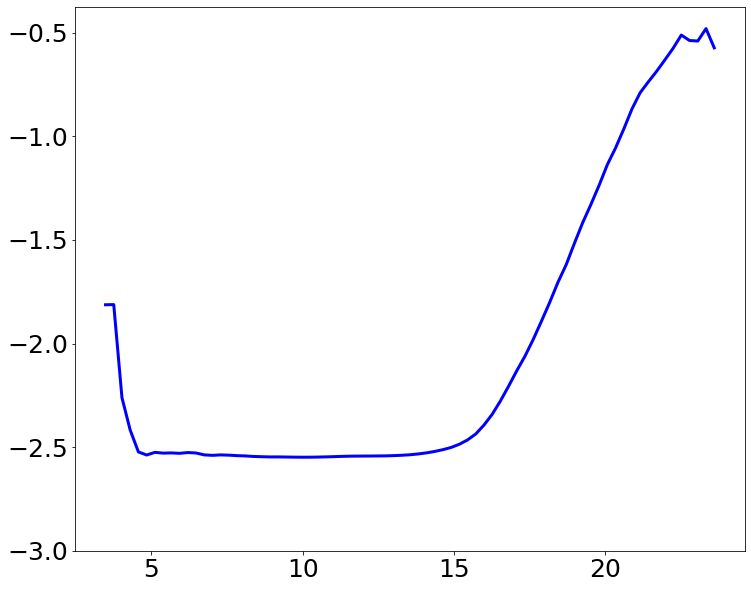

In [12]:
from scipy.stats import binned_statistic

bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

binnum = 75
bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

plt.figure(figsize=[12,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue')
plt.ylim(bottom=-3.0)

(-3.0, -0.5569026350975037)

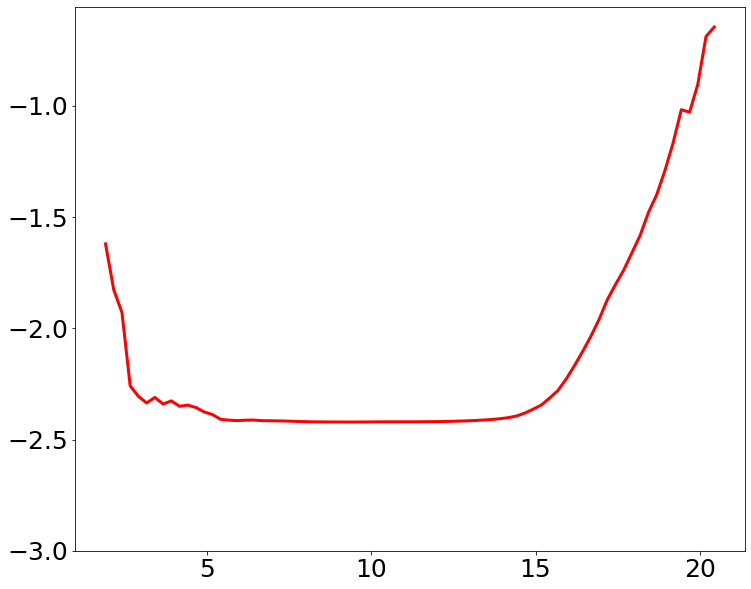

In [13]:
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

binnum = 75
rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

plt.figure(figsize=[12,10])
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red')
plt.ylim(bottom=-3.0)

Text(0, 0.5, 'Log(Error)')

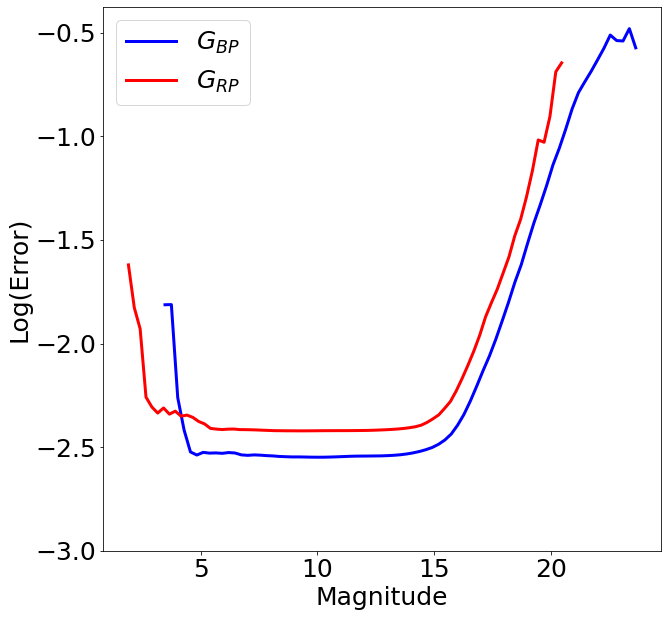

In [14]:
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
# plt.savefig('gaiaerrs.pdf',bbox_inches='tight')

Text(0, 0.5, 'Error')

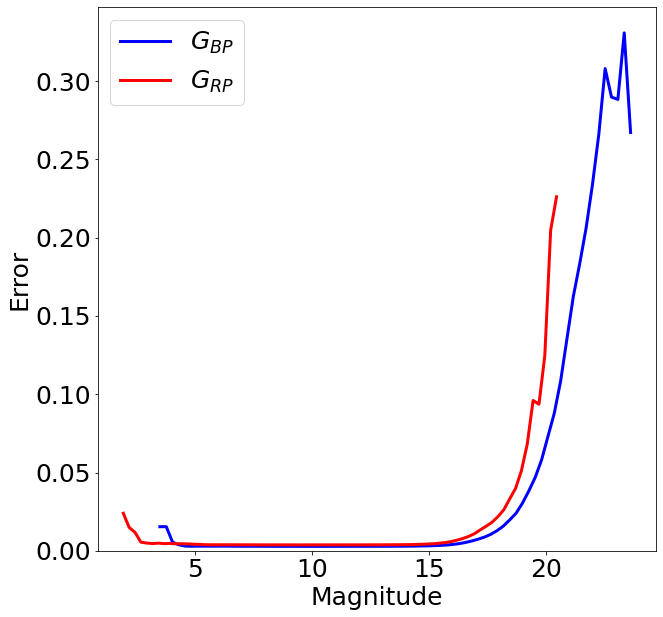

In [15]:
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),10**bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),10**rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=.0)
plt.xlabel('Magnitude')
plt.ylabel('Error')

In [17]:
bperrfunc = IUS(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
rperrfunc = IUS(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

bperr = 10**bperrfunc(gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'])
rperr = 10**rperrfunc(gcsdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'])

In [18]:
gcsdr17.columns

ColDefs(
    name = 'APOGEE_ID'; format = '30A'
    name = 'TELESCOPE'; format = '6A'
    name = 'FIELD'; format = '20A'
    name = 'ALT_ID'; format = '30A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'AK_TARG'; format = 'E'
    name = 'AK_TARG_METHOD'; format = '32A'
    name = 'AK_WISE'; format = 'E'
    name = 'SFD_EBV'; format = 'E'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET4'; format = 'J'
    name = 'TARGFLAGS'; format = '132A'
    name = 'SURVEY'; format = '32A'
    name = 'PROGRAMNAME'; format = '32A'
    name =

In [77]:
idx = 1024
cnalpha = np.array([gcsdr17['C_FE'][idx],gcsdr17['N_FE'][idx],gcsdr17['O_FE'][idx],gcsdr17['MG_FE'][idx],
                    gcsdr17['SI_FE'][idx],gcsdr17['S_FE'][idx],gcsdr17['CA_FE'][idx],gcsdr17['TI_FE'][idx]])

#,teff,feh,cnalpha,obsphot,obsphot_err,distance,isochrones,rv=3.1

phot = np.array([gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][idx],gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][idx],
                 gcsdr17['J'][idx],gcsdr17['H'][idx],gcsdr17['K'][idx]])
phot_err = np.array([bperr[idx],rperr[idx],gcsdr17['J_ERR'],gcsdr17['H_ERR'],gcsdr17['K_ERR']])

#11.5
CalcAge = AetasStellae(gcsdr17['TEFF'][idx],shiftfeh[idx],cnalpha,phot,phot_err,7500,massive)
CalcAge.extinct(11.5,verbose=True)
CalcAge.ak

<ipython-input-77-7706135fd0c5>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  phot_err = np.array([bperr[idx],rperr[idx],gcsdr17['J_ERR'],gcsdr17['H_ERR'],gcsdr17['K_ERR']])


Input [Age, teff, Salaris [Fe/H]]:  [11.5, 5081.361, -0.9320426358944494]
[age_lo,age_hi]:  [11.500057186992374, 11.524975212557806]
lgteff, min, max:  [3.70598, 3.5742, 3.7288]
 
0.02165 x + 2.001
3.70598
2.081730924181167
2.4451008
 
0.01081 x + 1.143
3.70598
1.1827008930099112
2.4451008
 
-0.0212 x + 0.7806
3.70598
0.7020644116880025
0.5800009
 
-0.02966 x + 0.4137
3.70598
0.3037489143491294
0.0880003
[ebpk,erpk,ejk,ehk]:  [0.19459622 1.17813896 0.04315965 0.01539886]
CCM:  [7.8544004  4.5963515  1.49019724 0.57737271]
Ak each band [0.02477544 0.25632047 0.02896238 0.02667057]
Calc Ak:  0.02781647562978899


0.02781647562978899

In [38]:
gcsdr17['AK_TARG'][idx]

0.011407976

In [39]:
cardelli_alav(leff['K'],3.1)/(cardelli_alav(0.445,3.1)-cardelli_alav(0.551,3.1))*0.03

0.011207885228845105

In [42]:
print('ebpk_k: ',(cardelli_alav(leff['BP'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1))
print('erpk_k: ',(cardelli_alav(leff['RP'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1))
print('ejk_k: ',(cardelli_alav(leff['J'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1))
print('ehk_k: ',(cardelli_alav(leff['H'],3.1)-cardelli_alav(leff['K'],3.1))/cardelli_alav(leff['K'],3.1))

ebpk_k:  7.85440040412002
erpk_k:  4.59635149547628
ejk_k:  1.4901972382364816
ehk_k:  0.5773727079807909


In [43]:
0.02781647562978899/0.011207885228845105

2.481866566424082

In [53]:
gcs['CLUSTER'][1024]
# teff,feh,cnalpha,obsphot,obsphot_err,distance,isochrones,rv=3.1

'M5'

In [76]:
p0=11.5
idx = 1024
cnalpha = np.array([gcsdr17['C_FE'][idx],gcsdr17['N_FE'][idx],gcsdr17['O_FE'][idx],gcsdr17['MG_FE'][idx],
                    gcsdr17['SI_FE'][idx],gcsdr17['S_FE'][idx],gcsdr17['CA_FE'][idx],gcsdr17['TI_FE'][idx]])

obs_mags = np.array([gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][idx],gcsdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][idx],
                     gcsdr17['J'][idx],gcsdr17['H'][idx],gcsdr17['K'][idx]],dtype=float).T.ravel()
obs_mags_err = np.array([bperr[idx],rperr[idx],gcsdr17['J'][idx],gcsdr17['H'][idx],
                         gcsdr17['K'][idx]],dtype=float).T.ravel()

CalcAge = AetasStellae(gcsdr17['TEFF'][idx],shiftfeh[idx],cnalpha,obs_mags,obs_mags_err,7500,massive)
CalcAge.extinct(11.5)
print(CalcAge.ak)

popt,pcov = curve_fit(CalcAge.teff2appmags2,gcsdr17['TEFF'][idx],obs_mags,p0=p0,bounds=(0.,14.),method='trf',
                      sigma=obs_mags_err,absolute_sigma=True)

CalcAge.extinct(popt[0])
print('Age',popt[0])
print('Ak',CalcAge.ak)

popt,pcov = curve_fit(CalcAge.teff2appmags2,gcsdr17['TEFF'][idx],obs_mags,p0=p0,bounds=(0.,14.),method='trf',
                      sigma=obs_mags_err,absolute_sigma=True)

CalcAge.extinct(popt[0])
print('Age',popt[0])
print('Ak',CalcAge.ak)

popt,pcov = curve_fit(CalcAge.teff2appmags2,gcsdr17['TEFF'][idx],obs_mags,p0=p0,bounds=(0.,14.),method='trf',
                      sigma=obs_mags_err,absolute_sigma=True)

print(popt[0])
print(CalcAge.ak)


# print('-----------')
# print('Initial',p0)
# print('Age',popt)
# print(pcov)
# print(np.sqrt(pcov[0][0]))
# # print(np.sqrt(pcov[1][1]))

0.02781647562978899
Age 7.324955673006343
Ak 0.028248607764051255
Age 7.374965552130426
Ak 0.02817898726876826
7.374965618934767
0.02817898726876826
